In [3]:
from gerrychain import (Graph, GeographicPartition, Election, updaters)
import numpy as np

natlDemVote = {"PRES12": 51.964, "PRES16": 51.113, "HOUSE18": 54.379, "PRES20": 52.294}

# some states do not have 2016 results
# NC has multiple assignments: oldplan (2011), newplan (2016), judge (2017)
dem_field_pres16 = {'GA': 'PRES16D', 'MI': 'PRES16D', 'MN': 'PRES16D', 'NC': 'EL16G_PR_D', 'OH': 'PRES16D',
                    'OR': 'PRES16D', 'PA': 'T16PRESD', 'TX': 'PRES16D', 'VA': 'G16DPRS', 'WI': 'PREDEM16'}
gop_field_pres16 = {'GA': 'PRES16R', 'MI': 'PRES16R', 'MN': 'PRES16R', 'NC': 'EL16G_PR_R', 'OH': 'PRES16R',
                    'OR': 'PRES16R', 'PA': 'T16PRESR', 'TX': 'PRES16R', 'VA': 'G16RPRS', 'WI': 'PREREP16'}
dem_field_gov18 = {'AZ': 'GOV18D', 'CO': 'GOV18D', 'MI': 'GOV18D', 'OR': 'GOV18D'}
gop_field_gov18 = {'AZ': 'GOV18R', 'CO': 'GOV18R', 'MI': 'GOV18R', 'OR': 'GOV18R'}
dem_field_house18 = {'AZ': 'USH18D', 'CO': 'USH18D', 'OR': 'USH18D'}
gop_field_house18 = {'AZ': 'USH18R', 'CO': 'USH18R', 'OR': 'USH18R'}
pop_field = {'AZ': 'TOTPOP', 'CO': 'TOTPOP', 'GA': 'TOTPOP', 'MI': 'TOTPOP', 'MN': 'TOTPOP', 'NC': 'TOTPOP',
             'OH': 'TOTPOP', 'OR': 'TOTPOP', 'PA': 'TOTPOP', 'TX': 'TOTPOP', 'VA': 'TOTPOP', 'WI': 'PERSONS'}
assignment_field = {'AZ': 'CD', 'CO': 'CD116FP', 'GA': 'CD', 'MI': 'CD', 'MN': 'CONGDIST', 'NC': 'newplan',
                    'OH': 'CD', 'OR': 'CD', 'PA': 'CD_2011', 'TX': 'USCD', 'VA': 'CD_16', 'WI': 'CON'}
projection_code = {'AZ': '2223', 'CO': '2957', 'GA': '4019', 'MI': '6493', 'MN': '26915', 'NC': '6543',
                   'OH': '3747', 'OR': '2338', 'PA': '26918', 'TX': '3081', 'VA': '3968', 'WI': '26916'}
county_field = {'AZ': 'COUNTY', 'CO': 'COUNTYFP', 'GA': 'CTYNAME', 'MI': 'county_nam', 'MN': 'COUNTYNAME', 'NC': 'County',
                'OH': 'COUNTY', 'OR': 'County', 'PA': 'COUNTYFP10', 'TX': 'COUNTY', 'VA': 'locality', 'WI': 'CNTY_NAME'}

STATE = 'GA'

YEAR = "2011"

ELECTION_USED = "PRES16"

DEM_VOTE, GOP_VOTE = 0, 0
if ELECTION_USED == "PRES16":
    DEM_VOTE = dem_field_pres16[STATE]
    GOP_VOTE = gop_field_pres16[STATE]
elif ELECTION_USED == "GOV18":
    DEM_VOTE = dem_field_gov18[STATE]
    GOP_VOTE = gop_field_gov18[STATE]
elif ELECTION_USED == "HOUSE18":
    DEM_VOTE = dem_field_house18[STATE]
    GOP_VOTE = gop_field_house18[STATE]
POP_FIELD_NAME = pop_field[STATE]
COUNTY_FIELD_NAME = county_field[STATE]
ASSIGNMENT = assignment_field[STATE]

graph = Graph.from_json(''.join([STATE, YEAR, '/', STATE, '_VTDs.json']))

elections = []
elections.append(Election(ELECTION_USED, {"Democratic": DEM_VOTE, "Republican": GOP_VOTE}))

# Population updater, for computing how close to equality the district
# populations are. POP_FIELD_NAME is the population column from our shapefile.
my_updaters = {"population": updaters.Tally(POP_FIELD_NAME, alias="population")}

# Election updaters, for computing election results using the vote totals
# from our shapefile.
election_updaters = {election.name: election for election in elections}
my_updaters.update(election_updaters)

partition = GeographicPartition(graph, assignment=ASSIGNMENT, updaters=my_updaters)

WHITE_POP = "NH_WHITE"
BLACK_POP = "NH_BLACK"
HISP_POP = "HISP"
ASIAN_POP = "NH_ASIAN"
#everyone else is "other" - all of these get subtracted from POP_FIELD_NAME
def minority_districts(partition):
    toReturn = {}
    for district in partition.parts:
        tot_pop, minority_pop = 0, 0
        for node in partition.parts[district]:
            tot_pop += partition.graph.nodes[int(node)][POP_FIELD_NAME]
            minority_pop += partition.graph.nodes[int(node)][POP_FIELD_NAME] - partition.graph.nodes[int(node)][WHITE_POP]
        # if minority_pop*2 >= tot_pop: num_districts += 1
        toReturn[district] = minority_pop/tot_pop
    return toReturn

minority_proportions = (minority_districts(partition))

import geopandas
import matplotlib.pyplot as plt
units = geopandas.read_file(''.join([STATE, YEAR, '/', STATE, '.shp']))
units.to_crs({"init": "epsg:"+projection_code[STATE]}, inplace=True)

C:\Users\Luke Wang\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [4]:
minority_to_unit_dict = {}
for district in partition.parts:
    for node in partition.parts[district]:
        if partition.graph.nodes[node][POP_FIELD_NAME] == 0: minority_to_unit_dict[node] = 0.5
        else: minority_to_unit_dict[node] = 1 - partition.graph.nodes[node][WHITE_POP]/partition.graph.nodes[node][POP_FIELD_NAME]
node_minority_proportions = [minority_to_unit_dict[i] for i in range(len(minority_to_unit_dict))]

In [5]:
def plotWithScale(partition, geometries=None, **kwargs):
    """Plot the partition, using the provided geometries.

    :param geometries: A :class:`geopandas.GeoDataFrame` or :class:`geopandas.GeoSeries`
        holding the geometries to use for plotting. Its :class:`~pandas.Index` should match
        the node labels of the partition's underlying :class:`~gerrychain.Graph`.
    :param `**kwargs`: Additional arguments to pass to :meth:`geopandas.GeoDataFrame.plot`
        to adjust the plot.
    """
    if geometries is None:
        geometries = partition.graph.geometry

    if set(geometries.index) != set(partition.graph.nodes):
        raise TypeError(
            "The provided geometries do not match the nodes of the graph."
        )
    assignment_series = partition.assignment.to_series()
    # for i in range(assignment_series.size):
    #     assignment_series.values[i] = minority_proportions[assignment_series.values[i]]
    if isinstance(geometries, geopandas.GeoDataFrame):
        geometries = geometries.geometry
    df = geopandas.GeoDataFrame(
        {"assignment": assignment_series}, geometry=geometries
    )
    
    return df.plot(column="assignment", **kwargs)



In [6]:
from matplotlib.colors import LinearSegmentedColormap
heatmap_colors = [(0, (0,0,0)), (0.5, (0.9,0.9,0.9)), (1, (0.5,0.7,0))]
minority_heatmap = LinearSegmentedColormap.from_list("custom", heatmap_colors)

In [7]:
district_colors = [0 for i in range(len(partition.parts))]
for district in partition.parts:
    district_num = int(district)-1
    minority_percent = minority_proportions[district]
    if minority_percent < 0.5:
        gray = 1.8*minority_percent
        district_colors[district_num] = (district_num/(len(partition.parts)-1), (gray, gray, gray))
    else:
        minority_percent -= 0.5
        red = 0.9 - 0.8*minority_percent
        green = 0.9 - 0.4*minority_percent
        blue = 0.9 - 1.8*minority_percent
        district_colors[district_num] = (district_num/(len(partition.parts)-1), (red, green, blue))
print(district_colors)

district_heatmap = LinearSegmentedColormap.from_list("custom", district_colors)

[(0.0, (0.7062738763759329, 0.7062738763759329, 0.7062738763759329)), (0.07692307692307693, (0.8346431632131902, 0.8673215816065951, 0.752947117229678)), (0.15384615384615385, (0.5675959910063522, 0.5675959910063522, 0.5675959910063522)), (0.23076923076923078, (0.7189025032576839, 0.8094512516288419, 0.4925306323297888)), (0.3076923076923077, (0.7264305642543984, 0.8132152821271992, 0.5094687695723965)), (0.38461538461538464, (0.6743536383702236, 0.6743536383702236, 0.6743536383702236)), (0.46153846153846156, (0.8982435644830372, 0.8991217822415186, 0.8960480200868337)), (0.5384615384615384, (0.6861624802641022, 0.6861624802641022, 0.6861624802641022)), (0.6153846153846154, (0.3706535461667502, 0.3706535461667502, 0.3706535461667502)), (0.6923076923076923, (0.5993356246512394, 0.5993356246512394, 0.5993356246512394)), (0.7692307692307693, (0.5533182363750927, 0.5533182363750927, 0.5533182363750927)), (0.8461538461538461, (0.7727378497621215, 0.7727378497621215, 0.7727378497621215)), (0

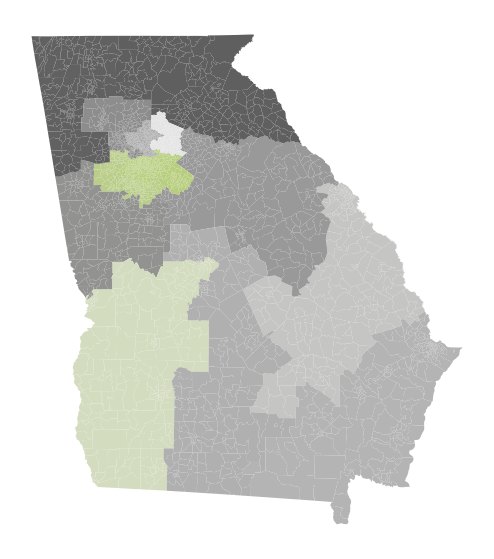

In [8]:
plotWithScale(partition, units, figsize=(10, 7), cmap=district_heatmap) # range color, color scale
# plt.pcolor(vmin=0, vmax=1)
# plt.clim(0,1)
plt.axis('off')
# plt.autoscale(False)
# plt.colorbar()
plt.show()